In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

Populating the interactive namespace from numpy and matplotlib


Understanding SSD Result
===

This notebook looks at how different loss scaling methods may affect the mixed precision training result on SSD models.

The SSD model we choose to compare on is `ssd512`, which uses VGG-16 as its backbone and takes in `(512, 512)` input images (maybe?).
It is trained on Pascal VOC 2007 and 2012 training sets and tested on VOC 2007 only.

The technical details about how we revised the implementation of that SSD architecture in `chainer` is listed in the `README.md` file.

In [2]:
import os
import sys
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.interpolate import spline
import seaborn as sns
sns.set()

In [128]:
DIRS = {
    # 'no_loss_scale': '/mnt/ccnas2/bdp/rz3515/train/ada_loss/object_detection/ssd512/no_loss_scale/',
    'ada_loss': '/mnt/ccnas2/bdp/rz3515/train/ada_loss/object_detection/ssd512/ada_loss/',
    'ada_loss_4GPU': '/mnt/ccnas2/bdp/rz3515/train/ada_loss/object_detection/ssd512/ada_loss.GPU_4.20190909',
    'ada_loss_freq_10': '/mnt/ccnas2/bdp/rz3515/train/ada_loss/object_detection/ssd512/ada_loss_freq_10/',
    'ada_loss (GPU=4,F=10)': '/mnt/ccnas2/bdp/rz3515/train/ada_loss/object_detection/ssd512/ada_loss.GPU_4_F_10.20190922/',
    'ada_loss (GPU=4,F=100)': '/mnt/ccnas2/bdp/rz3515/train/ada_loss/object_detection/ssd512/ada_loss.GPU_4_F_100.20190922/',
    'ada_loss (GPU=4,F=100) new': '/mnt/ccnas2/bdp/rz3515/train/ada_loss/object_detection/ssd512/ada_loss.GPU_4_F_100.20190924/',
    'ada_loss (GPU=4,F=100,AB=8192)': '/mnt/ccnas2/bdp/rz3515/train/ada_loss/object_detection/ssd512/ada_loss.GPU_4_F_100_AB_8192.20190924/',
    # diverged
#     'no_loss_scale': '/mnt/ccnas2/bdp/rz3515/train/ada_loss/object_detection/ssd512/no_loss_scale.GPU_16.20190912',
    'loss_scale_8': '/mnt/ccnas2/bdp/rz3515/train/ada_loss/object_detection/ssd512/loss_scale_8',
    'loss_scale_128': '/mnt/ccnas2/bdp/rz3515/train/ada_loss/object_detection/ssd512/loss_scale_128',
    'loss_scale_128_GPU4': '/mnt/ccnas2/bdp/rz3515/train/ada_loss/object_detection/ssd512/loss_scale_128.GPU_16.20190912',
    'loss_scale_256': '/mnt/ccnas2/bdp/rz3515/train/ada_loss/object_detection/ssd512/loss_scale_256',
    'dynamic_interval_10': '/mnt/ccnas2/bdp/rz3515/train/ada_loss/object_detection/ssd512/ada_loss.GPU_1_dyn.20190829',
    'dynamic_interval_10_GPU4': '/mnt/ccnas2/bdp/rz3515/train/ada_loss/object_detection/ssd512/dyn_intv_10.GPU_16.20190912'
}

## Show training logs

The cells below show the training curves of different loss scaling settings.

Note that the training without `no_loss_scale` terminates at the very beginning.

In [4]:
def load_train_log(train_dir):
    """ Load train log from the directory """
    return pd.read_json(os.path.join(train_dir, 'log'))

In [5]:
def plot_train_log(train_dir, label, ax, sample_freq=100):
    """ Plot a single train log on a give ax """
    log = load_train_log(train_dir)

    print(train_dir)
    if 'validation/main/map' in log:
        print('Best mAP={:.4f}'.format(log['validation/main/map'].max()))
    
    x = log['iteration'].values[::sample_freq]
    y = log['main/loss'].values[::sample_freq]
    
    ax.plot(x, y, label='{}'.format(label))

/mnt/ccnas2/bdp/rz3515/train/ada_loss/object_detection/ssd512/ada_loss/
Best mAP=0.7927
/mnt/ccnas2/bdp/rz3515/train/ada_loss/object_detection/ssd512/ada_loss.GPU_4.20190909
Best mAP=0.8030
/mnt/ccnas2/bdp/rz3515/train/ada_loss/object_detection/ssd512/ada_loss_freq_10/
Best mAP=0.7873
/mnt/ccnas2/bdp/rz3515/train/ada_loss/object_detection/ssd512/ada_loss.GPU_4_F_10.20190922/
Best mAP=0.7978
/mnt/ccnas2/bdp/rz3515/train/ada_loss/object_detection/ssd512/ada_loss.GPU_4_F_100.20190922/
Best mAP=0.8021
/mnt/ccnas2/bdp/rz3515/train/ada_loss/object_detection/ssd512/ada_loss.GPU_4_F_100.20190924/
Best mAP=0.7997
/mnt/ccnas2/bdp/rz3515/train/ada_loss/object_detection/ssd512/ada_loss.GPU_4_F_100_AB_8192.20190924/
Best mAP=0.8031
/mnt/ccnas2/bdp/rz3515/train/ada_loss/object_detection/ssd512/loss_scale_8
Best mAP=0.7883
/mnt/ccnas2/bdp/rz3515/train/ada_loss/object_detection/ssd512/loss_scale_128
Best mAP=0.7871
/mnt/ccnas2/bdp/rz3515/train/ada_loss/object_detection/ssd512/loss_scale_128.GPU_16.201

Text(0, 0.5, 'main/loss')

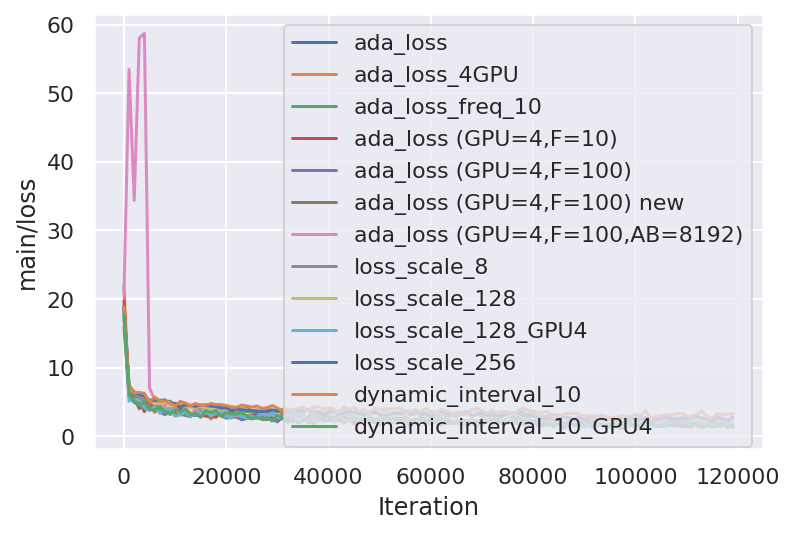

In [129]:
fig, ax = plt.subplots()

for label, train_dir in DIRS.items():  
    plot_train_log(train_dir, label, ax)

ax.legend()
ax.set_xlabel('Iteration')
ax.set_ylabel('main/loss')

## Average

In [109]:
train_dirs = [
    '/mnt/ccnas2/bdp/rz3515/train/ada_loss/object_detection/ssd512/loss_scale_128',
    '/mnt/ccnas2/bdp/rz3515/train/ada_loss/object_detection/ssd512/loss_scale_128.GPU_1.20190908',
    '/mnt/ccnas2/bdp/rz3515/train/ada_loss/object_detection/ssd512/loss_scale_128.GPU_1.20190912'
]
best_map = []
for train_dir in train_dirs:
    log = pd.read_json(os.path.join(train_dir, 'log'))
    map_ = log['validation/main/map'].max()
    best_map.append(map_)
    print(map_)
print(np.mean(best_map))

0.7870807335420551
0.7887824607361471
0.790356887946121
0.7887400274081077


In [103]:
train_dirs = [
    '/mnt/ccnas2/bdp/rz3515/train/ada_loss/object_detection/ssd512/loss_scale_8',
]
best_map = []
for train_dir in train_dirs:
    log = pd.read_json(os.path.join(train_dir, 'log'))
    best_map.append(log['validation/main/map'].max())
print(np.mean(best_map))

0.7882505753589131


In [108]:
train_dirs = [
    '/mnt/ccnas2/bdp/rz3515/train/ada_loss/object_detection/ssd512/ada_loss.GPU_1_F_10.20190831/',
]
best_map = []
for train_dir in train_dirs:
    log = pd.read_json(os.path.join(train_dir, 'log'))
    map_ = log['validation/main/map'].max()
    best_map.append(map_)
    print(map_)
print(np.mean(best_map))

0.792434174016666
0.792434174016666


## Final Validation Result

Below we show the comparison between different settings regarding mAP

In [7]:
import pickle
import re
import chainer
from collections import OrderedDict

In [8]:
SNAPSHOT_DIR='/mnt/ccnas2/bdp/rz3515/train/ada_loss/object_detection/ssd512/float32.20190908/grad_snapshots'

In [9]:
re.findall(r'_\d+', 'iter_0_cnt_100_func_Convolution2DGradW_idx_0')

['_0', '_100', '_0']

In [10]:
def load_snapshots(snapshot_dir):
    """ Load gradient snapshots """
    snapshot_files = os.listdir(snapshot_dir)
    grad_snaps = OrderedDict()
    # parse their iteration and counter
    for i, fp in enumerate(snapshot_files):
        if i % 100 == 0:
            print('==> Loaded {} number of snapshot files, {:.2f}% ...'.format(i + 1, (i + 1) / len(snapshot_files)))
        if 'ReLU' not in fp and 'Deconv' not in fp:
            continue
        nums = [int(s[1:]) for s in re.findall(r'_\d+', fp)]
        if len(nums) != 3:
            continue
        it, cnt, idx = nums
        if idx != 0:
            continue
        
        if it not in grad_snaps:
            grad_snaps[it] = {}
        grad_snaps[it][cnt] = fp
    
    
    grad_snaps_ = OrderedDict()
    for it in sorted(grad_snaps.keys()):
        grad_snaps_[it] = OrderedDict()
        base = min(grad_snaps[it].keys())
        idx = 0
        for cnt in sorted(grad_snaps[it].keys()):
            fp = os.path.join(snapshot_dir, grad_snaps[it][cnt])
            data =  pickle.load(open(fp, "rb" )) 
            xp = chainer.backend.get_array_module(data)
            if xp != np:
                data = xp.asnumpy(data)
            grad_snaps_[it][idx] = (grad_snaps[it][cnt], data)
            idx += 1
    
    return grad_snaps_

In [11]:
snaps = load_snapshots(SNAPSHOT_DIR)

==> Loaded 1 number of snapshot files, 0.00% ...
==> Loaded 101 number of snapshot files, 0.04% ...
==> Loaded 201 number of snapshot files, 0.08% ...
==> Loaded 301 number of snapshot files, 0.12% ...
==> Loaded 401 number of snapshot files, 0.16% ...
==> Loaded 501 number of snapshot files, 0.20% ...
==> Loaded 601 number of snapshot files, 0.24% ...
==> Loaded 701 number of snapshot files, 0.28% ...
==> Loaded 801 number of snapshot files, 0.32% ...
==> Loaded 901 number of snapshot files, 0.36% ...
==> Loaded 1001 number of snapshot files, 0.40% ...
==> Loaded 1101 number of snapshot files, 0.44% ...
==> Loaded 1201 number of snapshot files, 0.48% ...
==> Loaded 1301 number of snapshot files, 0.52% ...
==> Loaded 1401 number of snapshot files, 0.56% ...
==> Loaded 1501 number of snapshot files, 0.60% ...
==> Loaded 1601 number of snapshot files, 0.64% ...
==> Loaded 1701 number of snapshot files, 0.68% ...
==> Loaded 1801 number of snapshot files, 0.72% ...
==> Loaded 1901 number o

In [12]:
[(k, v[0], v[1].shape) for k, v in snaps[0].items()]

[(0, 'iter_0_cnt_3_func_Deconvolution2DFunction_idx_0.pkl', (8, 16, 1, 1)),
 (1, 'iter_0_cnt_5_func_Deconvolution2DFunction_idx_0.pkl', (8, 84, 1, 1)),
 (2, 'iter_0_cnt_7_func_ReLUGrad2_idx_0.pkl', (8, 256, 1, 1)),
 (3, 'iter_0_cnt_8_func_Deconvolution2DFunction_idx_0.pkl', (8, 256, 1, 1)),
 (4, 'iter_0_cnt_9_func_Deconvolution2DFunction_idx_0.pkl', (8, 16, 1, 1)),
 (5, 'iter_0_cnt_10_func_Deconvolution2DFunction_idx_0.pkl', (8, 16, 2, 2)),
 (6, 'iter_0_cnt_12_func_Deconvolution2DFunction_idx_0.pkl', (8, 84, 2, 2)),
 (7, 'iter_0_cnt_13_func_Deconvolution2DFunction_idx_0.pkl', (8, 84, 1, 1)),
 (8, 'iter_0_cnt_14_func_ReLUGrad2_idx_0.pkl', (8, 128, 2, 2)),
 (9, 'iter_0_cnt_15_func_Deconvolution2DFunction_idx_0.pkl', (8, 128, 2, 2)),
 (10, 'iter_0_cnt_17_func_ReLUGrad2_idx_0.pkl', (8, 256, 2, 2)),
 (11, 'iter_0_cnt_18_func_Deconvolution2DFunction_idx_0.pkl', (8, 256, 2, 2)),
 (12, 'iter_0_cnt_20_func_Deconvolution2DFunction_idx_0.pkl', (8, 24, 4, 4)),
 (13, 'iter_0_cnt_22_func_Deconvoluti

In [13]:
iters = [10000, 50000, 80000, 110000]

In [107]:
per_ufs = {}
for it in iters:
    per_ufs[it] = []
    for k, v in snaps[it].items():
        per_ufs[it].append(np.sum(np.abs(v[1]) < 6e-8) / v[1].size * 100)

In [15]:
loss_scales = {}
for it in iters:
    loss_scales[it] = []
    for k, v in snaps[it].items():
        abs_grad = np.abs(v[1])
        abs_grad = abs_grad[abs_grad < 6e-8]
        abs_grad = abs_grad[abs_grad > 0]
        if abs_grad.size < 100:
            loss_scales[it].append(1)
        else:
            min_grad = np.sort(abs_grad)[int(abs_grad.size * 0.001)]
            loss_scales[it].append(6e-8 / min_grad)

In [14]:
overflow_loss_scales = {}
for it in iters:
    max_grad = 0
    for k, v in snaps[it].items():
        max_ = np.abs(v[1]).max() 
        if max_ > max_grad:
            max_grad = max_
    print(max_grad)
    u_max = 8192
    overflow_loss_scales[it] = u_max / max_grad
overflow_loss_scales

0.008547009
0.004878049
0.006134969
0.0037593986


{10000: 958463.9526901268,
 50000: 1679359.9984359741,
 80000: 1335296.0310897834,
 110000: 2179071.94520569}

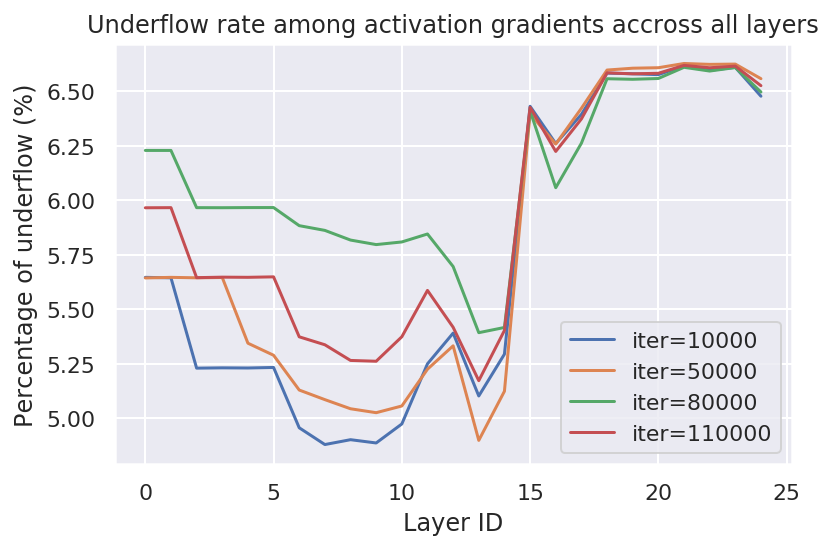

In [129]:
fig, ax = plt.subplots()

for it in per_ufs.keys():
    ax.plot(np.log2(per_ufs[it]), label='iter={}'.format(it))

ax.set_xlabel('Layer ID')
ax.set_ylabel('Percentage of underflow (%)')
ax.set_title('Underflow rate among activation gradients accross all layers')
ax.legend()

plt.tight_layout()
fig.savefig('./SSD512_underflow_rate.pdf')

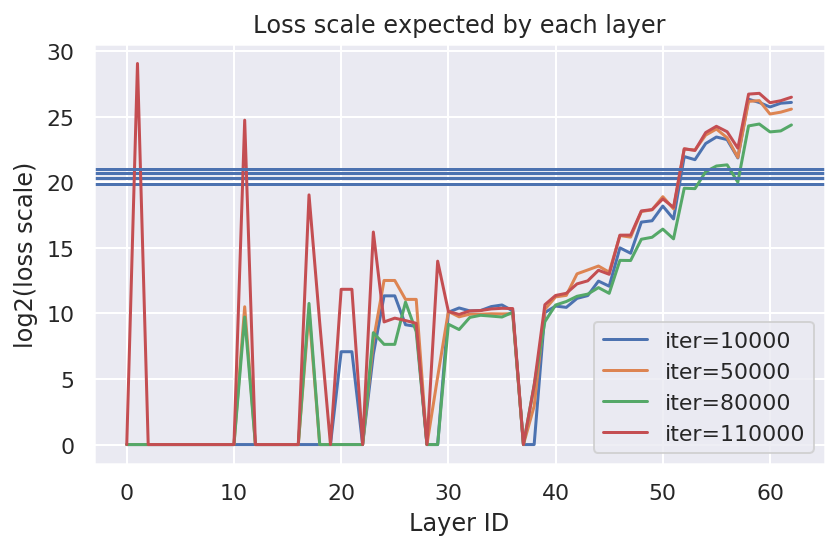

In [16]:
fig, ax = plt.subplots()

for it in loss_scales.keys():
    ax.plot(np.log2(loss_scales[it]), label='iter={}'.format(it))
    ax.axhline(np.log2(overflow_loss_scales[it]))
    
ax.set_xlabel('Layer ID')
ax.set_ylabel('log2(loss scale)')
ax.set_title('Loss scale expected by each layer')
ax.legend()

plt.tight_layout()
fig.savefig('./SSD512_expected_loss_scale.pdf')

## Loss scale

In [117]:
train_dir = '/mnt/ccnas2/bdp/rz3515/train/ada_loss/object_detection/ssd512/ada_loss'
fp = os.path.join(train_dir, 'loss_scale.csv')
df = pd.read_csv(fp, index_col=0)

In [118]:
df.loc[df['val'].idxmax()]

iter                           105800
label    AdaLossConvolution2DFunction
key                           unbound
val                           283.708
Name: 165152, dtype: object

In [123]:
print(df[(df['iter'] == 105800)].to_string())

          iter                         label           key         val
165048  105800  AdaLossConvolution2DFunction       unbound    1.000000
165049  105800  AdaLossConvolution2DFunction         bound    1.000000
165050  105800  AdaLossConvolution2DFunction  power_of_two    1.000000
165051  105800  AdaLossConvolution2DFunction         final    1.000000
165052  105800  AdaLossConvolution2DFunction       unbound    1.000000
165053  105800  AdaLossConvolution2DFunction         bound    1.000000
165054  105800  AdaLossConvolution2DFunction  power_of_two    1.000000
165055  105800  AdaLossConvolution2DFunction         final    1.000000
165056  105800  AdaLossConvolution2DFunction       unbound    1.620799
165057  105800  AdaLossConvolution2DFunction         bound    1.620799
165058  105800  AdaLossConvolution2DFunction  power_of_two    1.000000
165059  105800  AdaLossConvolution2DFunction         final    1.000000
165060  105800  AdaLossConvolution2DFunction       unbound    1.000000
165061

## Sanity Check

In [72]:
train_dirs = {
    'ada_loss': '/mnt/ccnas2/bdp/rz3515/train/ada_loss/object_detection/ssd512/ada_loss.GPU_1_F_10_AB_2048.20190912',
    'loss_scale_128': '/mnt/ccnas2/bdp/rz3515/train/ada_loss/object_detection/ssd512/loss_scale_128.GPU_1.20190912',
}

In [73]:
dfs = {}
for key, val in train_dirs.items(): 
    dfs[key] = pd.read_csv(os.path.join(val, 'sanity_check.csv'), index_col=0)

Plot the difference in underflow rate:

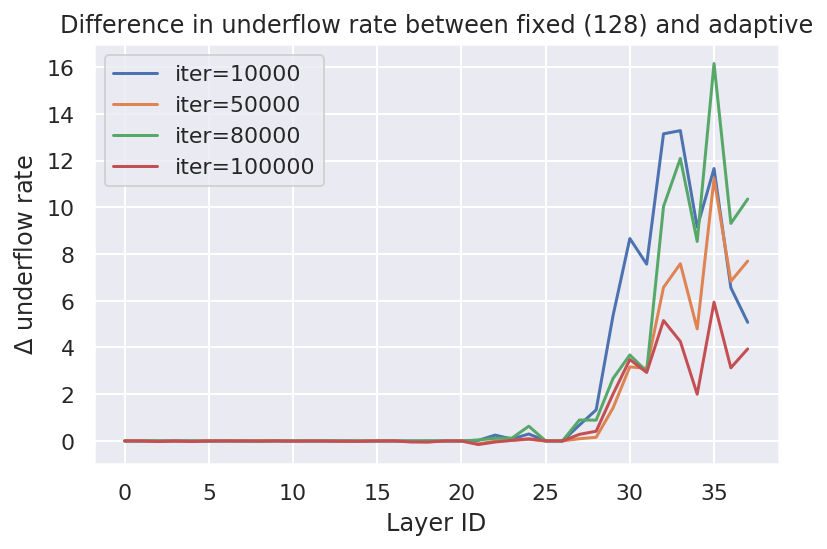

In [101]:
for it in [10000, 50000, 80000, 100000]:
    df1 = dfs['ada_loss'][df['iter'] == it]
    df2 = dfs['loss_scale_128'][df['iter'] == it]

    plt.plot(np.arange(len(df_)),
             (- df2['nuf_ls']) - (- df1['nuf_ls']),
             label='iter={}'.format(it))

plt.legend()
plt.xlabel('Layer ID')
plt.ylabel(r'$\Delta$ underflow rate')
plt.title('Difference in underflow rate between fixed (128) and adaptive')
plt.tight_layout()
plt.savefig('SSD512_diff_underflow_rate.pdf')

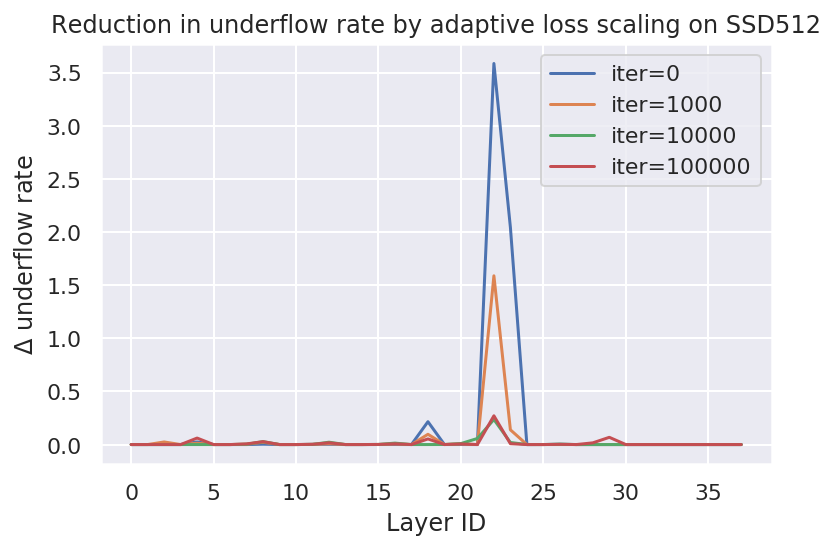

In [46]:
for it in [0, 1000, 10000, 100000]:
    df_ = df[df['iter'] == it]
    plt.plot(np.arange(len(df_)),
             df_['nuf_ls'] - df_['nuf_fp16'],
             label='iter={}'.format(it))
    
plt.xlabel('Layer ID')
plt.ylabel(r'$\Delta$ underflow rate')
plt.title('Reduction in underflow rate by adaptive loss scaling on SSD512')
plt.legend()
plt.tight_layout()
plt.savefig('SSD512_underflow_rate_loss_scaled.pdf')

## Profiling

In [62]:
train_dir = '/mnt/ccnas2/bdp/rz3515/train/ada_loss/object_detection/ssd512/ada_loss.GPU_1.20190920'
train_log = pd.read_json(os.path.join(train_dir, 'log'))
profile = pd.read_csv(os.path.join(train_dir, 'profile.csv'), index_col=0)

In [63]:
profile

,event_name,time_elapsed
0,calc_stat,100.253507
1,total,180.276337


In [65]:
full = (train_log['elapsed_time'].max() - train_log['elapsed_time'].min()) / (train_log['iteration'].max() - train_log['iteration'].min())

In [69]:
profile[profile['event_name'] == 'calc_stat']['time_elapsed'] / train_log['iteration'].max() / full * 100

0    27.131027
Name: time_elapsed, dtype: float64

In [70]:
profile[profile['event_name'] == 'total']['time_elapsed'] / train_log['iteration'].max() / full * 100

1    48.787143
Name: time_elapsed, dtype: float64